# Imports

In [201]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime


# Variables and Utils

In [232]:
nodes = ["10.2.0.10", "10.2.0.11", "10.2.0.12"]
client = "10.2.0.2"
server = "10.2.0.3"

allServers = nodes + [client, server]
print(allServers)

def to_human_readable(size):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    return "{0} {1}".format(size, mem[n])

['10.2.0.10', '10.2.0.11', '10.2.0.12', '10.2.0.2', '10.2.0.3']


# Data Preparation

In [203]:
df = pd.read_json('export.log', lines = True)

df = (pd.DataFrame(df['jsonPayload'].values.tolist())
        .add_prefix('jsonPayload.')
        .join(df.drop('jsonPayload', 1)))
df = (pd.DataFrame(df['jsonPayload.connection'].values.tolist())
        .add_prefix('jsonPayload.connection.')
        .join(df.drop('jsonPayload.connection', 1)))
df = df.dropna(subset=['jsonPayload.rtt_msec'])
df = df.astype({
    'jsonPayload.bytes_sent': 'int32',
    'jsonPayload.rtt_msec': 'int32'
    })
df = df.astype({'jsonPayload.connection.src_port': 'int32'})
df = df.astype({'jsonPayload.connection.dest_port': 'int32'})
df.set_index('timestamp', inplace=True)
# Filter Entries for internal Traffic which is where the Benchmark Traffic is
df = df[df["jsonPayload.connection.src_ip"].isin(allServers)]
df = df[df["jsonPayload.connection.dest_ip"].isin(allServers)]

# Print Table
df[["jsonPayload.connection.src_ip", "jsonPayload.connection.dest_ip", "jsonPayload.bytes_sent", "jsonPayload.rtt_msec"]].head()
# df.info()

,jsonPayload.connection.src_ip,jsonPayload.connection.dest_ip,jsonPayload.bytes_sent,jsonPayload.rtt_msec
timestamp,,,,
2021-07-07 12:21:58.964009+00:00,10.2.0.2,10.2.0.10,569,0
2021-07-07 12:23:02.889347+00:00,10.2.0.2,10.2.0.10,508,1
2021-07-07 12:23:04.460703+00:00,10.2.0.2,10.2.0.10,508,0
2021-07-07 12:27:38.499437+00:00,10.2.0.2,10.2.0.10,374,0
2021-07-07 12:27:39.960981+00:00,10.2.0.2,10.2.0.10,508,0


In [204]:
fromClient = df[df['jsonPayload.connection.src_ip']=='10.2.0.2']
toServer = df[df['jsonPayload.connection.dest_ip']=='10.2.0.3']


fromClientDataset = {}
toServerDataset = {}
betweenNodesDataset = {}
for node in nodes: 
    fromClientDataset[node] = fromClient[fromClient['jsonPayload.connection.dest_ip']==node]

nodeCombinations = list(itertools.combinations(nodes, r=2))
for combination in nodeCombinations: 
    # Use both src_ip and dest_ip as they are not request related
    fromNode = df[df['jsonPayload.connection.src_ip'].isin(combination)]
    # fromAnyNode = df[df["jsonPayload.connection.src_ip"].isin(nodes)]
    betweenNodesDataset["between " + combination[0] + " and " + combination[1]] = fromNode[fromNode['jsonPayload.connection.dest_ip'].isin(combination)]

for node in nodes: 
    toServerDataset[node] = toServer[toServer['jsonPayload.connection.src_ip']==node]



# print(nodeCombinations)
# fromClientTo4 = fromClientTo4[fromClientTo4['jsonPayload.connection.dest_port']==8080]
# fromClientTo4 = fromClientTo4[fromClientTo4['jsonPayload.bytes_sent']!=0]
# toServer.head()
# toServerDataset["10.2.0.12"].head()
# betweenNodesDataset['to' + nodes[0]].info()
# fromClientTo4['jsonPayload.connection.protocol'].value_counts()
# fromClientTo4['jsonPayload.bytes_sent'].value_counts()
# fromClientTo4.info()

# Results

## General

Text(0.5, 1.0, 'Round Trip Time Histogram')

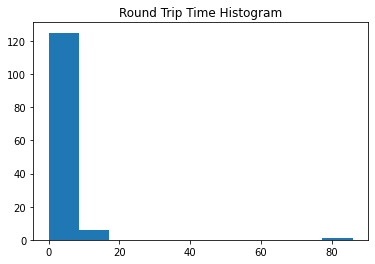

In [205]:
fig, ax = plt.subplots()
remove0 = df[df['jsonPayload.bytes_sent']!=0]
ax.hist(remove0['jsonPayload.rtt_msec'])
ax.set_title("Round Trip Time Histogram")

## Case: Baseline (Central Mongo)

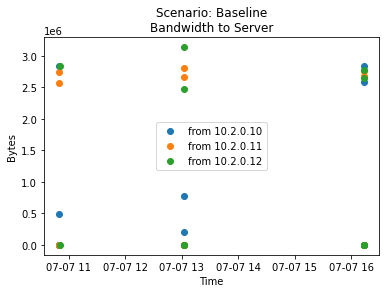

In [206]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label="from " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Baseline\nBandwidth to Server')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.legend()
fig.savefig("out/bandwidth_to_server.png")

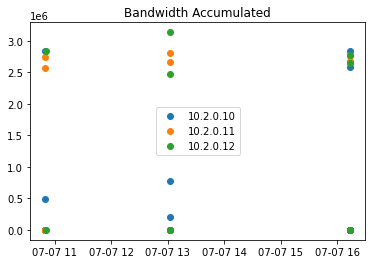

In [207]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in toServerDataset: 
    ax.plot(toServerDataset[key].index, toServerDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Bandwidth Accumulated')
ax.legend()

## Case: Syncmesh

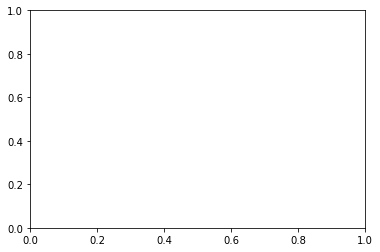

In [208]:
fig, ax = plt.subplots()
# plot histogram
binwidth = 10

# ax.hist(fromClientTo4['jsonPayload.bytes_sent'], bins=range(min(fromClientTo4['jsonPayload.bytes_sent']), max(fromClientTo4['jsonPayload.bytes_sent']) + binwidth, binwidth))
# ax.set_title("Package Size Histogram for Client to 4")

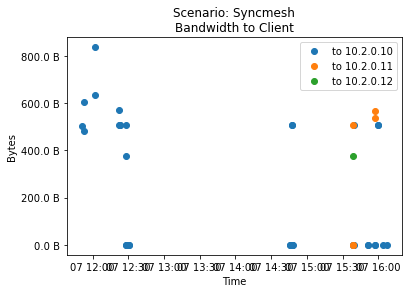

In [233]:
fig, ax = plt.subplots()
# ax.set_ylim(0,500)
for key in fromClientDataset: 
    ax.plot(fromClientDataset[key].index, fromClientDataset[key]["jsonPayload.bytes_sent"], label="to " + key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth to Client')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend()
# fig.savefig("out/bandwidth_from_client.png")
plt.show()

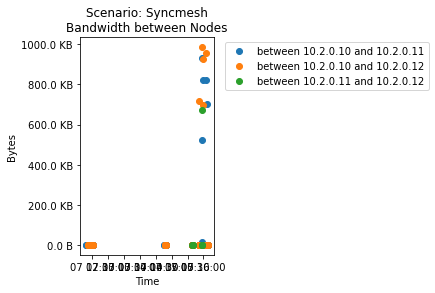

In [234]:
fig, ax = plt.subplots()



# ax.set_ylim(0,500)
for key in betweenNodesDataset: 
    ax.plot(betweenNodesDataset[key].index, betweenNodesDataset[key]["jsonPayload.bytes_sent"], label=key, marker='o', linestyle='None')
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("Bytes")
ax.set_xlabel("Time")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

fig.savefig("out/bandwidth_between_nodes.png")
plt.show()

# Comparison

[16320040, 703702, 6238487]


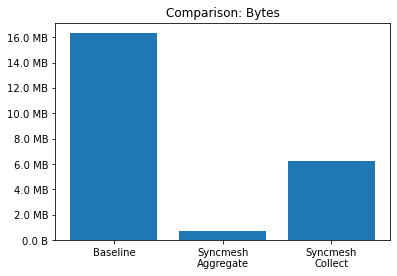

In [235]:
timedfbaseline = df.loc['2021-7-7 16:10':'2021-7-7 16:14']

baselineAggregateBytes = timedfbaseline["jsonPayload.bytes_sent"].sum()
baselineAggregateRTT = timedfbaseline["jsonPayload.rtt_msec"].sum()

timedfaggregate = df.loc['2021-7-7 16:06':'2021-7-7 16:08']

syncmeshAggregateBytes = timedfaggregate["jsonPayload.bytes_sent"].sum()
syncmeshAggregateRTT = timedfaggregate["jsonPayload.rtt_msec"].sum()

timedfcollect = df.loc['2021-7-7 16:03':'2021-7-7 16:05']

syncmeshCollectBytes = timedfcollect["jsonPayload.bytes_sent"].sum()
syncmeshCollectRTT = timedfcollect["jsonPayload.rtt_msec"].sum()

# timedfbaseline.info()

fig, ax = plt.subplots()
cases = ['Baseline', 'Syncmesh\nAggregate', 'Syncmesh\nCollect']
values = [baselineAggregateBytes, syncmeshAggregateBytes, syncmeshCollectBytes]
print(values)
ax.bar(cases,values)
ax.set_title('Comparison: Bytes')
ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                    ax.get_yticks(minor=False)])
# ax.set_ylabel("Bytes")
# ax.set_xlabel("Time")
fig.savefig("out/comparison.png")
plt.show()

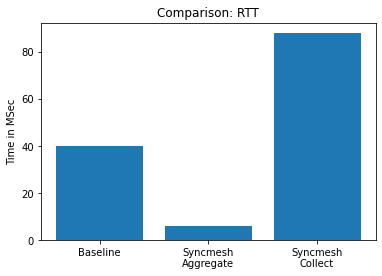

In [236]:
fig, ax = plt.subplots()
cases = ['Baseline', 'Syncmesh\nAggregate', 'Syncmesh\nCollect']
values = [baselineAggregateRTT, syncmeshAggregateRTT, syncmeshCollectRTT]
ax.bar(cases,values)
ax.set_title('Comparison: RTT')
ax.set_ylabel("Time in MSec")
# ax.set_xlabel("Time")
fig.savefig("out/comparison_rtt.png")
plt.show()